## Chelyabinsk extended optimization

#### installing related dependencies 

In [6]:
import pandas as pd
from deepimpact import Planet
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import interp1d

chelyabinsk_data = pd.read_csv('../resources/ChelyabinskEnergyAltitude.csv')
chelyabinsk_data.columns = ['chely_h', 'chely_dedz']
chelyabinsk_data['chely_h'] = chelyabinsk_data['chely_h']*1000

In [7]:
def solver_output(r, Y):
    input = {'radius': r,
            'velocity': 19e3,
            'density': 3300.,
            'strength': Y,
            'angle': 20,
            'init_altitude': 100e3,
            'dt':0.05}

    earth = Planet()
    result = earth.solve_atmospheric_entry(**input, radians=False)
    result = earth.calculate_energy(result)
    result = result[['altitude','dedz']]
    return result

### Loss Function 

In traditional optimization problems, metrics such as Mean Squared Error (MSE) or Root Mean Squared Error (RMSE) are commonly minimized. However, these classical statistical measures may not align well with the specific context of certain projects.

In the case of the DeepImpact project, the primary objective is to quantify the impact of an asteroid from a damage control perspective. This necessitates a shift in focus from conventional metrics to parameters that are more relevant to the project's goals.

Key among these parameters are:
- **Maximum Energy Change per Unit Altitude (max\_dedz):** This metric represents the peak energy alteration at a given altitude, which is crucial in understanding the potential impact of an asteroid.
- **Altitude at Maximum Energy Change (altitude of max(dedz)):** Identifying the specific altitude where this maximum energy change occurs is vital for accurate impact assessments.

Given this context, the tailored loss function for the DeepImpact project should prioritize minimizing these two parameters: `max_dedz` and the altitude at which it occurs. This approach will ensure a more effective and contextually relevant optimization for assessing asteroid impacts.

This loss function `loss_func()` is tailored to the specific requirements of the DeepImpact project, as outlined in your earlier markdown text. The primary goal is to accurately simulate or predict the impact of an asteroid in terms of energy change at various altitudes. The function provides two ways to measure the accuracy of the solver: one focusing on the peak energy change and its altitude (relevant for assessing the most significant impact point), and the other on the overall accuracy across different altitudes (useful for a more comprehensive assessment of the impact profile).

The default of the loss function is `metric='peak_distantce'`. The loss is calculated as the square root of the sum of squared differences between the solver's max dedz altitude and value and those of the Chelyabinsk event, multiplied by the absolute differences of both max dedz and altitude. This loss metric emphasizes the importance of matching both the magnitude of energy change and the altitude at which it occurs.

In [8]:
def loss_func(solver,chelyabinsk, metric='peak_distantce'):
    # max_value_index = chelyabinsk['chely_dedz'].idxmax()
    # # Get all rows up to and including the row with the maximum value
    # chelyabinsk = chelyabinsk.loc[:max_value_index]
    if metric == 'peak_distantce': 
        chelyabinsk_max_dedz_z= 29557.8
        chely_max_dedz = 81.50500

        solver_max_dedz_index = solver['dedz'].idxmax()
        solver_max_dedz_z = solver.loc[solver_max_dedz_index, 'altitude']
        solver_max_dedz = solver['dedz'].max()
        metric = np.sqrt((chelyabinsk_max_dedz_z-solver_max_dedz_z)**2+(chely_max_dedz-solver_max_dedz)**2)*abs(chely_max_dedz-solver_max_dedz)*abs(chelyabinsk_max_dedz_z-solver_max_dedz_z)
        return metric
    else: 
        x_known = solver['altitude'] # Known x-values
        y_known = solver['dedz'] # Corresponding y-values
        # New x values for interpolation/extrapolation
        x_new = chelyabinsk['chely_h']
        # Create an interpolation function (default is linear interpolation)
        f_linear = interp1d(x_known, y_known)
        # Use the interpolation functions to estimate y values for the new x values
        interpolated_solver_dedz = f_linear(x_new)
        #y_cubic = f_cubic(x_new)

        squared_diff = (interpolated_solver_dedz - chelyabinsk['chely_h']) ** 2
        # Compute the mean of squared differences
        mse = np.mean(squared_diff)
        # Compute the RMSE (square root of the mean squared error)
        rmse = np.sqrt(mse)
        return rmse

def optimization_function(params):
    r, Y = params
    solver_data = solver_output(r, Y)
    return loss_func(solver_data, chelyabinsk_data)

### `get_initial_guess` Function for DeepImpact Project

The `get_initial_guess` function is a crucial component in the DeepImpact project, aimed at determining an initial guess for the parameters of an asteroid that could replicate the impact similar to the Chelyabinsk event.

- **Purpose:** To generate an initial set of parameters (strength and radius) for an asteroid that closely matches the impact characteristics of the Chelyabinsk event.
- **Method:** The function explores a range of possible values for the asteroid's strength and radius and evaluates each combination against a custom loss metric.
1. **Parameter Space Definition:**
   - `limit_list`: A list of 20 equally spaced values between 1e6 and 5e6, representing different possible strengths of the asteroid.
   - `radius_list`: A list of 20 equally spaced values between 2 and 20, representing different possible radii of the asteroid.
2. **Reference Values from Chelyabinsk Event:**
   - `chelyabinsk_max_dedz_z`: The altitude at which the maximum energy change occurred during the Chelyabinsk event.
   - `chely_max_dedz`: The maximum energy change per unit altitude for Chelyabinsk.
3. **Evaluation Loop:**
   - For each combination of strength (`Y`) and radius (`r`), the function calls `solver_output` to simulate the impact.
   - It then calculates a custom loss metric based on how closely the simulated impact matches the Chelyabinsk event in terms of max dedz and its altitude.
   - These metrics are stored along with the corresponding strength and radius values.
4. **Optimal Parameters Identification:**
   - The function identifies the combination of strength and radius that results in the smallest loss metric.
   - These optimal parameters are then plotted in a 3D scatter plot, highlighting the most suitable initial guess.
5. **Result:**
   - The function returns the optimal parameters (radius and strength) that offer the closest match to the Chelyabinsk event's impact characteristics.


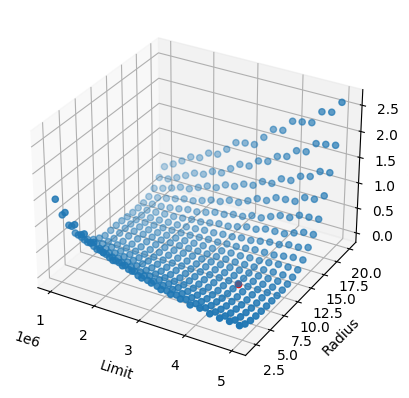

In [9]:

def get_initail_guess():
# Generating 100 points between 1e6 and 3e6
    limit_list = np.linspace(1e6, 5e6, 20)
    radius_list = np.linspace(2, 20, 20)

    chelyabinsk_max_dedz_z= 29557.8
    chely_max_dedz = 81.50500

    strength = []
    radius = []
    metric_list = []

    for Y in limit_list:
        for r in radius_list:
            solver_solution = solver_output(r,Y)
            solver_max_dedz_index = solver_solution['dedz'].idxmax()
            solver_max_dedz_z = solver_solution.loc[solver_max_dedz_index, 'altitude']
            solver_max_dedz = solver_solution['dedz'].max()
            metric = np.sqrt((chelyabinsk_max_dedz_z-solver_max_dedz_z)**2+(chely_max_dedz-solver_max_dedz)**2)*abs(chely_max_dedz-solver_max_dedz)*abs(chelyabinsk_max_dedz_z-solver_max_dedz_z)
            strength.append(Y)
            radius.append(r)
            metric_list.append(metric)

    # Retrieve the corresponding elements from limit and radius
    min_index = metric_list.index(min(metric_list))
    optimal_strength = strength[min_index]
    optimal_radius = radius[min_index]
    smallest_metric = metric_list[min_index]
    optimal_param = [optimal_radius,optimal_strength ]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # Plot the data
    ax.scatter(optimal_strength, optimal_radius, smallest_metric,  color='red')
    ax.scatter(strength, radius, metric_list)
    # Set labels for axes
    ax.set_xlabel('Limit')
    ax.set_ylabel('Radius')
    ax.set_zlabel('Metric')
    # Show the plot
    plt.show()
    return optimal_param

initial_guess_param = get_initail_guess()
initial_guess = [initial_guess_param[0], initial_guess_param[1]]



### Detailed Explanation of Bounds Definition and Minimization Execution

#### 1. Bounds Definition

- **Code Snippet:** `bounds = [(1, 20), (1e6, 5e6)]`
- **Purpose:** These bounds define the permissible range for the parameters that the optimization algorithm will explore. In this context:
  - The first tuple `(1, 20)` specifies the lower and upper limits for the radius of the asteroid.
  - The second tuple `(1e6, 5e6)` sets the boundaries for the yield strength of the asteroid.
- **Significance:** By setting these bounds, the algorithm is constrained to search within realistic and physically plausible ranges. This ensures that the solutions found are feasible in the context of asteroid impact simulations.

#### 2. Minimization Execution using the Nelder-Mead Method

- **Code Snippet:** `result = minimize(optimization_function, initial_guess, bounds=bounds, method='Nelder-Mead')`
- **Method Choice - Nelder-Mead:**
  - The Nelder-Mead algorithm is a widely used heuristic method for multidimensional unconstrained optimization. It does not require the gradient of the objective function, making it suitable for functions that are not smooth or differentiable.
  - This method is particularly effective for complex, nonlinear functions that might challenge gradient-based optimization methods.
- **Why Nelder-Mead in DeepImpact Project?**
  - **Non-Differentiable Functions:** In the context of the DeepImpact project, the optimization function might be complex, with discontinuities or non-differentiable behavior, especially when simulating physical phenomena like asteroid impacts.
  - **Simplicity and Robustness:** Nelder-Mead is known for its simplicity and robustness, which can be advantageous in exploratory stages of the project where the objective function's behavior is not fully understood.
  - **No Gradient Requirement:** The lack of a requirement for derivatives is beneficial if the objective function is computationally intensive or difficult to differentiate analytically.
- **Process:**
  - The algorithm iteratively adjusts a simplex of points in the parameter space to probe and find the minimum of the function.
  - It starts with the `initial_guess` and explores the parameter space within the defined `bounds` to find the combination of radius and yield strength that minimizes the objective function.

#### Overall Context and Importance

- The combination of well-defined bounds and the use of the Nelder-Mead optimization method ensures that the search for optimal parameters is both targeted and adaptable. 
- This approach is particularly suited for the complex and potentially irregular landscape of the optimization problem posed in the DeepImpact project.


Optimal Radius: 8.651390575769458, Optimal Yield Strength: 4055728.0900385715


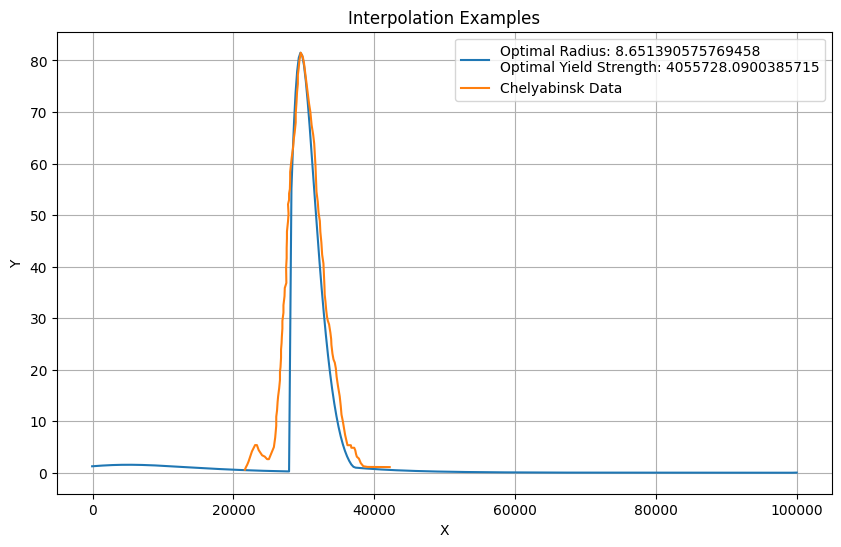

808.18691723968
0.524124754768923


In [11]:

bounds = [(1, 20), (1e6, 5e6)]
# Perform the minimization
result = minimize(optimization_function, initial_guess, bounds=bounds, method='Nelder-Mead')
# Extract the optimal values
optimal_r, optimal_Y = result.x
print(f"Optimal Radius: {optimal_r}, Optimal Yield Strength: {optimal_Y}")
optimal_result = solver_output(r=optimal_r,Y=optimal_Y)

plt.figure(figsize=(10, 6))
plt.plot(optimal_result['altitude'],optimal_result['dedz'], label=f"Optimal Radius: {optimal_r} \nOptimal Yield Strength: {optimal_Y}")
plt.plot(chelyabinsk_data['chely_h'],chelyabinsk_data['chely_dedz'], label='Chelyabinsk Data')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Interpolation Examples')
plt.grid(True)
plt.show()

print(optimization_function(initial_guess))
print(optimization_function(result.x))